<a href="https://colab.research.google.com/github/moosunny/Graph-Neural-Networks-Practice/blob/main/Chapter%206.%20%20Intoroducing%20Graph%20Convolution%20Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Chapter 6. Intoroducing Graph Convolution Networks

이번 챕터에서는 그래프 컨볼루션 네트워크를 소개한고 이전 챕터에서 소개된 Vanilla GNN 의 한게점에 대해 이야기한다.

또한, 이전에는 다루지 않았던 Node Regression 문제에 GNN을 적용하여 정형 데이터에도 GNN이 유용함을 확인한다.

그래프 구조는 Tabular와 이미지 데이터와 다르게 개별 노드가 보유한 이웃 노드의 개수는 노드 마다 상이하다.

$$ h_i = \sum_{j \in N_i} x_j W^T $$

상기 수식의 경우 개별 노드에 대한 이웃 노드 개수의 차이를 고려하지 않는다. 만약에 1번 노드가 보유한 이웃 노드의 수가 1000개, 2번 노드가 1개 보유하고 있다고 가정했을 때, 임베딩 된 $h_A$와 $h_B$를 효과적으로 비교하기 위한 방법이 필요하다.

따라서, 하기 수식과 같이 임베딩 이웃 노드의 개수에 따라 개별 임베딩 값을 나누어 주면 된다.

$$ h_i = \frac{1}{deg_{(i)}} \sum_{j \in N_i} x_j W^T $$

이를 통해, 이웃 노드 수를 반영한 차수 행렬을 생성하여 정규화 계수를 추가해주면 된다.

In [77]:
import numpy as np

D = np.array([
    [3, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 2, 0],
    [0, 0, 0, 2]
])

print(np.linalg.inv(D), end = "\n\n") # D 행렬의 역행렬

# 차수 행렬을 구하기 위한 D^-1, self loop를 반영하기 위해 항등행렬을 더해줌
D_inv = np.linalg.inv(D + np.identity(4))

print(D_inv)

[[0.33333333 0.         0.         0.        ]
 [0.         1.         0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.5       ]]

[[0.25       0.         0.         0.        ]
 [0.         0.5        0.         0.        ]
 [0.         0.         0.33333333 0.        ]
 [0.         0.         0.         0.33333333]]


노드의 feature 정보를 담은 input 행렬 A와 차수 행렬 D를 앞 혹은 뒤에 곱해주는지에 따라 두가지 효과가 있다.

1. $ \tilde{D}^{-1} \tilde{A} X W^T $: 모든 열에 대한 정규화
2. $  \tilde{A}\tilde{D}^{-1} X W^T $: 모든 행에 대한 정규화

In [ ]:
# 모든 열에 대한 정규화
A = np.array([
    [1, 1, 1, 1],
    [1, 1, 0, 0],
    [1, 0, 1, 1],
    [1, 0, 1, 1]
])

print(np.linalg.inv(D + np.identity(4)) @ A)

[[0.25       0.25       0.25       0.25      ]
 [0.5        0.5        0.         0.        ]
 [0.33333333 0.         0.33333333 0.33333333]
 [0.33333333 0.         0.33333333 0.33333333]]


In [ ]:
# 모든 행에 대한 정규화
A = np.array([
    [1, 1, 1, 1],
    [1, 1, 0, 0],
    [1, 0, 1, 1],
    [1, 0, 1, 1]
])

print(A @ np.linalg.inv(D + np.identity(4)))

[[0.25       0.5        0.33333333 0.33333333]
 [0.25       0.5        0.         0.        ]
 [0.25       0.         0.33333333 0.33333333]
 [0.25       0.         0.33333333 0.33333333]]


실제로 두가지 방법을 모두 코드를 통해 확인 했을 때, 열을 정규화한 경우의 각 열의 합은 1이고 행을 정규화한 경우는 각 행의 합이 1인 것을 확인할 수 있다.

GCN의 저자들은 이 두가지 정규화 방식을 혼용한 hybrid 방식의 정규화 방법을 제안했다. 이웃이 많은 노드의 특징이 고립된 노드의 특징과 달리 매우 쉽게 퍼진다는 것을 발견했고, 이를 해결하기 위해 이웃 노드가 적은 노드의 가중치가 더 높도록 유도하는 정규화 식을 개발했다.

$$H =  \tilde{D}^{-\frac{1}{2}} \tilde{A^T} \tilde{D}^{-\frac{1}{2}}W^T $$

개별 임베딩 측면에서 이 수식은 다음과 같다.

$$ h_i = \sum_{j \in N_i}\frac{1}{\sqrt{\deg(i)} \sqrt{\deg(j)}} x_j W^T $$

이웃이 많은 노드의 특징이 잘 퍼진다(spread)라는 표현이 있는데, 이는 정규화가 잘 되지 않거나 없을 경우 이웃이 없는 노드에 비해 이웃 노드로 부터 많은 영향을 받고 정규화 과정에서 갖고 있는 특징값의 평균화(퍼진다.)가 많이 될 가능성이 높다.



### Comparing graph convolution and graph linear layers

이번 챕터에서는 이전 챕터에서 활용한 Cora, Facebook page 데이터에서의 성능 평가를 진행한다.

Vanilla GNN과 다르게 GCN의 메인 특징은 노드 차수를 고려하여 feature에 가중치를 부여한다는 것이다. 본격적인 GCN 구현 전에 노드의 차수를 두개 데이터 셋을 대상으로 분석한다.

GCN 레이어는 노드 별로 차수값(해당 노드가 보유한 이웃 노드의 수) 차이가 클 경우에 성능이 좋을 것으로 예상할 수 있다. 만약 모든 노드의 차수가 동일한 경우에는 $(\sqrt{deg(i)} \sqrt{deg(i)}) = deg(i)$ 로 수식화할 수 있다.

In [2]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.7 MB/s eta 0:00:00


In [3]:
pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.5.0+cu124.html

Looking in links: https://data.pyg.org/whl/torch-2.5.0+cu124.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 51.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 72.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 97.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 84.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 37.7 MB/s eta 0:00:00


In [141]:
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import degree
from collections import Counter
import matplotlib.pyplot as plt

In [142]:
dataset = Planetoid(root = '.', name = 'Cora')
data = dataset[0]
data

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [29]:
# 각 노드가 보유한 이웃 노드의 개수를 출력하기 위함
degrees = degree(data.edge_index[0]).numpy()
degrees

array([3., 3., 5., ..., 1., 4., 4.], dtype=float32)

하기, 분포를 통해 노드별로 보유한 이웃 노드의 개수가 불균형 함을 확인할 수 있다.

In [73]:
def plot_degrees(data):
  degrees = degree(data.edge_index[0]).numpy()

  numbers = Counter(degrees) # key = 이웃 노드 개수, value = 빈도

  fig, ax = plt.subplots()
  ax.set_xlabel('Node degrees')
  ax.set_ylabel('Number of nodes')
  plt.bar(numbers.keys(), numbers.values())

<BarContainer object of 37 artists>

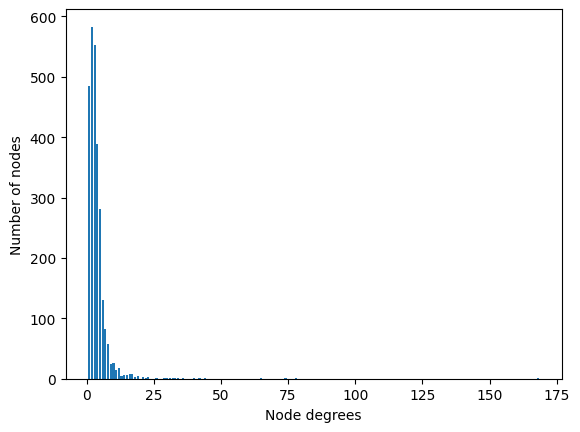

In [30]:
numbers = Counter(degrees) # key = 이웃 노드 개수, value = 빈도

fig, ax = plt.subplots()
ax.set_xlabel('Node degrees')
ax.set_ylabel('Number of nodes')
plt.bar(numbers.keys(), numbers.values())

<BarContainer object of 233 artists>

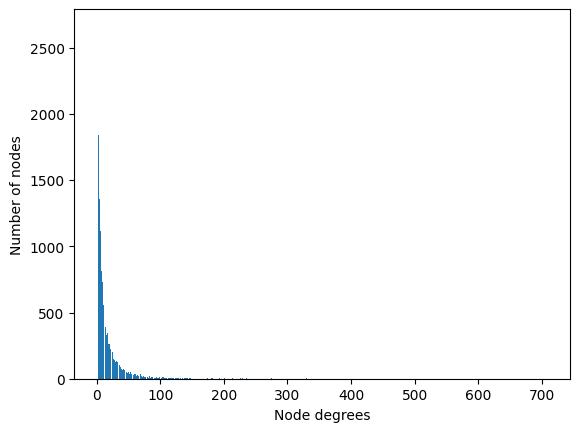

In [20]:
# Facebook page 데이터의 경우도 노드별로 보유한 이웃 노드의 개수가 불균형하다.
from torch_geometric.datasets import FacebookPagePage
dataset = FacebookPagePage(root = '.')
data = dataset[0]

degrees = degree(data.edge_index[0]).numpy()

numbers = Counter(degrees) # key = 이웃 노드 개수, value = 빈도

fig, ax = plt.subplots()
ax.set_xlabel('Node degrees')
ax.set_ylabel('Number of nodes')
plt.bar(numbers.keys(), numbers.values())

## Implementing GCN

In [31]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

In [32]:
# Metric 정의
def accuracy(pred_y, y):
  return ((pred_y == y).sum()/len(y)).item()

In [49]:
class GCN(torch.nn.Module):
  def __init__(self, dim_in, dim_h, dim_out):
    super().__init__()
    self.gcn1 = GCNConv(dim_in, dim_h)
    self.gcn2 = GCNConv(dim_h, dim_out)

  def forward(self, x, edge_index):
    h = self.gcn1(x, edge_index)
    h = torch.relu(h)
    h = self.gcn2(h, edge_index)

    return F.log_softmax(h, dim = 1)

  def fit(self, data, epochs):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(self.parameters(), lr = 0.01, weight_decay = 5e-4)

    self.train()
    for epoch in range(epochs+1):
      optimizer.zero_grad()
      out = self(data.x, data.edge_index)
      loss = criterion(out[data.train_mask], data.y[data.train_mask])
      acc = accuracy(out[data.train_mask].argmax(dim = 1), data.y[data.train_mask])
      loss.backward()
      optimizer.step()

      if epoch % 20 == 0:
        val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
        val_acc = accuracy(out[data.val_mask].argmax(dim = 1), data.y[data.val_mask])
        print(f'Epoch {epoch} | Train Loss: {loss:.4f} | Train Acc: {acc:4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}')

  @torch.no_grad()
  def test(self, data):
    self.eval()
    out = self(data.x, data.edge_index)
    acc = accuracy(out[data.test_mask].argmax(dim = 1), data.y[data.test_mask])

    return acc

In [50]:
gcn = GCN(dataset.num_features, 16, dataset.num_classes)
print(gcn)
gcn.fit(data, epochs = 200)

GCN(
  (gcn1): GCNConv(1433, 16)
  (gcn2): GCNConv(16, 7)
)
Epoch 0 | Train Loss: 1.9442 | Train Acc: 0.178571 | Val Loss: 1.9447 | Val Acc: 0.1140
Epoch 20 | Train Loss: 0.1240 | Train Acc: 1.000000 | Val Loss: 0.7800 | Val Acc: 0.7660
Epoch 40 | Train Loss: 0.0163 | Train Acc: 1.000000 | Val Loss: 0.7392 | Val Acc: 0.7600
Epoch 60 | Train Loss: 0.0157 | Train Acc: 1.000000 | Val Loss: 0.7322 | Val Acc: 0.7680
Epoch 80 | Train Loss: 0.0181 | Train Acc: 1.000000 | Val Loss: 0.7289 | Val Acc: 0.7720
Epoch 100 | Train Loss: 0.0167 | Train Acc: 1.000000 | Val Loss: 0.7302 | Val Acc: 0.7740
Epoch 120 | Train Loss: 0.0148 | Train Acc: 1.000000 | Val Loss: 0.7318 | Val Acc: 0.7740
Epoch 140 | Train Loss: 0.0134 | Train Acc: 1.000000 | Val Loss: 0.7329 | Val Acc: 0.7740
Epoch 160 | Train Loss: 0.0124 | Train Acc: 1.000000 | Val Loss: 0.7344 | Val Acc: 0.7760
Epoch 180 | Train Loss: 0.0115 | Train Acc: 1.000000 | Val Loss: 0.7357 | Val Acc: 0.7740
Epoch 200 | Train Loss: 0.0109 | Train Acc: 1.

In [53]:
acc = gcn.test(data)
print(f'Test Accuracy: {acc*100:.2f}%')

Test Accuracy: 81.50%


## Predicting web traffic with node regression

머신러닝에서는 회귀(regression)는 continuous 값을 예측하는 것이다. 그래프 데이터에서의 회귀는 각 노드의 continuous value 예측을 수행하는 것이다.

In [180]:
from torch_geometric.datasets import WikipediaNetwork
import torch_geometric.transforms as T

dataset = WikipediaNetwork(root = '.', name = 'chameleon', transform = T.RandomNodeSplit(num_val = 200, num_test = 500))
data = dataset[0]

In [181]:
print('Dataset:',dataset)
print('-'*20)
print(f'Number of graphs: {len(dataset)}')
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Numver of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

Dataset: WikipediaNetwork()
--------------------
Number of graphs: 1
Number of nodes: 2277
Number of edges: 36101
Numver of features: 2325
Number of classes: 5


In [182]:
len(data.train_mask)

2277

In [183]:
data.train_mask.shape

torch.Size([2277])

<BarContainer object of 63 artists>

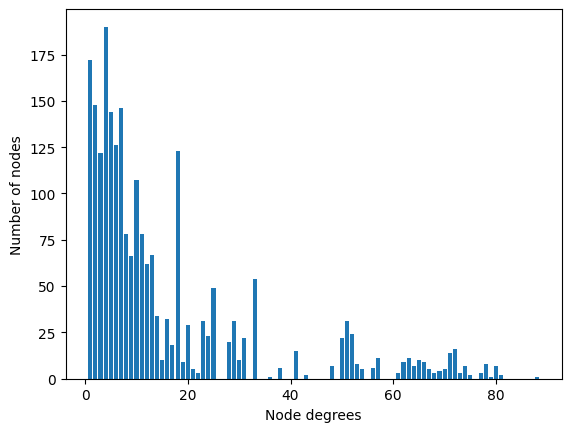

In [184]:
degrees = degree(data.edge_index[0]).numpy()

numbers = Counter(degrees) # key = 이웃 노드 개수, value = 빈도

fig, ax = plt.subplots()
ax.set_xlabel('Node degrees')
ax.set_ylabel('Number of nodes')
plt.bar(numbers.keys(), numbers.values())

In [185]:
data.train_mask

tensor([ True,  True,  True,  ...,  True, False,  True])

위키피디아의 카멜레온 데이터의 target은 5개의 Categorical 값을 갖지만, 회귀 문제에서는 적합하지 않은 target이기 때문에 회귀에 활용 가능한 형태의 Continuous 데이터를 다운 받아 활용한다.

In [186]:
from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile

url = 'https://snap.stanford.edu/data/wikipedia.zip'
with urlopen(url) as zurl:
    with ZipFile(BytesIO(zurl.read())) as zfile:
        zfile.extractall('.')

In [187]:
import pandas as pd

df = pd.read_csv('wikipedia/chameleon/musae_chameleon_target.csv')
values = np.log10(df['target']) # 로그 스케일링
data.y = torch.tensor(values)
data.y

tensor([2.2330, 3.9079, 3.9329,  ..., 1.9956, 4.3598, 2.4409],
       dtype=torch.float64)

<ipython-input-188-44a0bb27526f>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['target'], fit = norm)


<Axes: xlabel='target', ylabel='Density'>

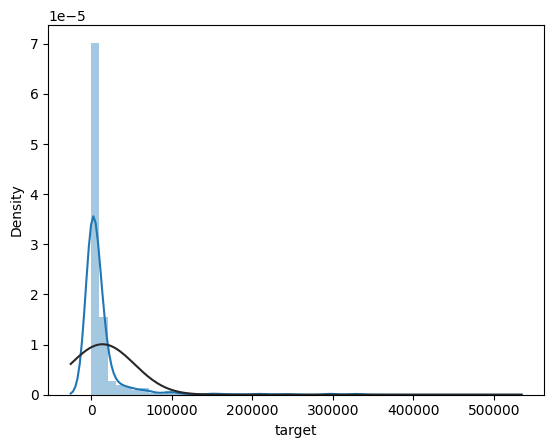

In [188]:
import seaborn as sns
from scipy.stats import norm

df['targert'] = values
sns.distplot(df['target'], fit = norm)

In [195]:
class GCN(torch.nn.Module):
  def __init__(self, dim_in, dim_h, dim_out):
    super().__init__()
    self.gcn1 = GCNConv(dim_in, dim_h*4)
    self.gcn2 = GCNConv(dim_h*4, dim_h*2)
    self.gcn3 = GCNConv(dim_h*2, dim_h)
    self.linear = torch.nn.Linear(dim_h, dim_out)

  def forward(self, x, edge_index):
    h = self.gcn1(x, edge_index)
    h = torch.relu(h)
    h = F.dropout(h, p = 0.5, training = self.training)
    h = self.gcn2(h, edge_index)
    h = torch.relu(h)
    h = F.dropout(h, p = 0.5, training = self.training)
    h = self.gcn3(h, edge_index)
    h = torch.relu(h)
    h = self.linear(h)
    return h

  def fit(self, data, epochs):
    optimizer = torch.optim.Adam(self.parameters(), lr = 0.02, weight_decay = 5e-4)


    self.train()
    for epoch in range(epochs+1):
      optimizer.zero_grad()
      out = self(data.x, data.edge_index)
      # print(out.squeeze()[data.train_mask[:, 0]])
      # print(data.y.shape)
      loss = F.mse_loss(out.squeeze()[data.train_mask], data.y[data.train_mask].float())
      loss.backward()
      optimizer.step()

      if epoch % 20 == 0:
        # print(out.squeeze()[data.val_mask].shape)
        val_loss = F.mse_loss(out.squeeze()[data.val_mask], data.y[data.val_mask].float())
        print(f'Epoch {epoch} | Train Loss: {loss:.4f} | Val Loss: {val_loss:.4f}')

  @torch.no_grad()
  def test(self, data):
    self.eval()
    out = self(data.x, data.edge_index)
    loss = F.mse_loss(out.squeeze()[data.test_mask], data.y[data.test_mask].float()) # F.mse_loss 와 nn.torch.MSEloss 차이 확인 필요

    return loss

In [196]:
gcn = GCN(dataset.num_features, 128, 1)
print(gcn)

gcn.fit(data, epochs = 200)

GCN(
  (gcn1): GCNConv(2325, 512)
  (gcn2): GCNConv(512, 256)
  (gcn3): GCNConv(256, 128)
  (linear): Linear(in_features=128, out_features=1, bias=True)
)
Epoch 0 | Train Loss: 12.4132 | Val Loss: 12.2648
Epoch 20 | Train Loss: 11.6002 | Val Loss: 11.4712
Epoch 40 | Train Loss: 7.6687 | Val Loss: 7.4517
Epoch 60 | Train Loss: 2.6386 | Val Loss: 3.4441
Epoch 80 | Train Loss: 0.6235 | Val Loss: 0.9679
Epoch 100 | Train Loss: 0.5331 | Val Loss: 0.9956
Epoch 120 | Train Loss: 0.3819 | Val Loss: 0.6614
Epoch 140 | Train Loss: 0.3417 | Val Loss: 0.7555
Epoch 160 | Train Loss: 0.3173 | Val Loss: 0.6775
Epoch 180 | Train Loss: 0.2891 | Val Loss: 0.6999
Epoch 200 | Train Loss: 0.3096 | Val Loss: 0.6890


In [198]:
loss = gcn.test(data)
loss

tensor(0.7215)